# **競賽說明**

本次的任務是要分辨哪些貼文是跟災難有關係的.<br>

本次項目為NLP–**單一文本分類任務**<br>

競賽網址:<br>
https://www.kaggle.com/competitions/nlp-getting-started

## kernel架構:
    1. 讀取套件及載入資料 
    2. EDA 
    3. Data Preprocessing(資料前處理) 
    4. 模型建構 


問題思考和想法

- 還需加入定義問題的部分?<br>
- 需加入各個列的相關性之間以及預測結果的相關性.<br>
- 我要怎麼顯示TFbertmodel的裡面的各個層?<br>
- 必須搞清楚模型的輸入輸出type<br>
這樣才能更好的進行操作.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# **1. 載入資料及套件**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#skleran
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#transformers 
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from transformers import TFBertModel

#tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical,plot_model 
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout 

#other
import missingno as msno
from IPython.display import clear_output

In [3]:
#導入資料

train=pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')

# **2. EDA**

## **2.1 資料概述**

關於資料的狀況<br>
其實是可以通過競賽的資料說明去了解的<br>
不過這邊我選擇通過代碼操作的方式來嘗試了解<br>
也試圖透過這樣視覺化資料的一些重要資訊.<br>

問題思考和想法: <br>

- 要如何呈現資料?該呈現的資訊有甚麼?<br>
各個列的含意.<br>
列包含的各種值.<br>
資料缺失狀況.<br>
文本長度及數量.<br>
- 可能要加入相關性部分<br>

In [4]:
train.info()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.info()
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## **2.2 Column**

- `id` : text的鍵值
- `text` : 從推特收錄的文本
- `location` : 發文的位置
- `keyword` : 某些出現在文本中的關鍵字
- `target` : 只有trainset有這個列. 表示是否為與災難相關的文本,0為否1為是.

實際上本次的項目基本上只會把text帶入模型之中<br>
希望透過讓模型自己去了解文本的語意<br>
而去預測與災難的關聯性<br>
不過在這邊我們還是會嘗試著做基本的資料探討分析.<br>

In [6]:
print(f'''
traindata columns :
{train.columns}
數量 : {len(train.columns)}

testdata columns :
{test.columns}
數量 : {len(test.columns)}
''')


traindata columns :
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
數量 : 5

testdata columns :
Index(['id', 'keyword', 'location', 'text'], dtype='object')
數量 : 4



### **2.2.1 id** 

id列為資料的鍵值

In [7]:
#確認鍵值是否有重複
#若下面輸出不為0則別是有重複

print('id重複數 : {}'.format(train.duplicated(keep=False).sum()))

id重複數 : 0


### **2.2.2 keyword**

keyword列的值大多是跟災難、糾紛、或是會帶來傷害性的事情有關的詞<br>
在這邊類似文本的tag.

- 問題思考:
    1. 有無關鍵字的資料分別為多少?
    2. 有關鍵字的資料會更有可能跟災難有關嗎?
    3. 是否有某些特定的值比較可能跟災難有關?


- 觀察:
    1. 資料中<br>
    有keyword值的為7552筆<br>
    沒有keyword值的為61筆(此處直接將值為nan的資料視為沒有值).<br>
    而去對比target值<br>
    值為0的有4342筆<br>
    值為1的有3271筆<br>
    2. 兩個列的數量相差太多<br>
    因此這邊判斷keyword跟target比較沒有相關性.<br>
    3. 從後面的比例圖來看<br>
    有某些詞比較高比例的與災難有關<br>
    不過有高比例的詞並不是少數<br>
    並且也沒有特別突出的數值.<br>
    另一方面<br>
    keyword的實質語意以及是否與災難有關<br>
    並沒有發現這之間具有明顯的關聯性.<br>

In [8]:
#排除掉keyword列值為nan的資料
#並挑幾筆拿出來

train[~train['keyword'].isna()].head(6)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [9]:
#了解keyword列包含哪些值以及其數量

print("{0:12}{1:1}".format('keyword值', '累計數量'))
print('')
print(train['keyword'].value_counts()[0:15])

print('')
print('-'*50) #為甚麼打印出來的東西前面會多一個空格?

print('keyword值:')
print(train['keyword'].unique()[0:30])

keyword值    累計數量

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64

--------------------------------------------------
keyword值:
[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging']


In [10]:

#是否具有值的數量
print('keywordr值具有值的數量: {}'.format(len(train[~train['keyword'].isna()])))
print('keyword值為nan的數量: {}'.format(len(train[train['keyword'].isna()])))

print('')

#target的值及其對應數量
print('target值為0和1分別的數量:')
print(train['target'].value_counts())

keywordr值具有值的數量: 7552
keyword值為nan的數量: 61

target值為0和1分別的數量:
0    4342
1    3271
Name: target, dtype: int64


In [11]:
# keyword為X,target為1的數量及其比例.

#邏輯:
#先建立擁有類別keyword個別數量
#和其類別中target為1的數量的表
#之後在另外補上計算占比的列


testdf1=train[['keyword','target']].groupby('keyword').count()
#這邊需要注意的是
#因為可能有keyword根本沒有target為1的的資料
#因此這樣挑出來的可能會有些keyword沒有被包含進去.
testdf2=train[train['target']==1][['keyword','target']] \
    .groupby('keyword').count() 
#testdf2

keyword_group=pd.concat([testdf1,testdf2],axis=1)
keyword_group.columns=['totel','num of 1']
#此處可以發現keyword_group中有值為空值的資料
#因此必須用0去取代
# keyword_group[keyword_group.isna().any(1)]
keyword_group.fillna(0,inplace=True)
keyword_group['占比']=keyword_group['num of 1']/keyword_group['totel']

print('keyword總組別數: {}'.format(keyword_group.shape[0]))
print('-'*50)
#占比前15高的分組
keyword_group.sort_values('占比',ascending=False).head(15)

keyword總組別數: 221
--------------------------------------------------


,totel,num of 1,占比
keyword,,,
debris,37,37.0,1.000000
wreckage,39,39.0,1.000000
derailment,39,39.0,1.000000
outbreak,40,39.0,0.975000
oil%20spill,38,37.0,0.973684
typhoon,38,37.0,0.973684
suicide%20bombing,33,32.0,0.969697
suicide%20bomber,31,30.0,0.967742
bombing,29,27.0,0.931034


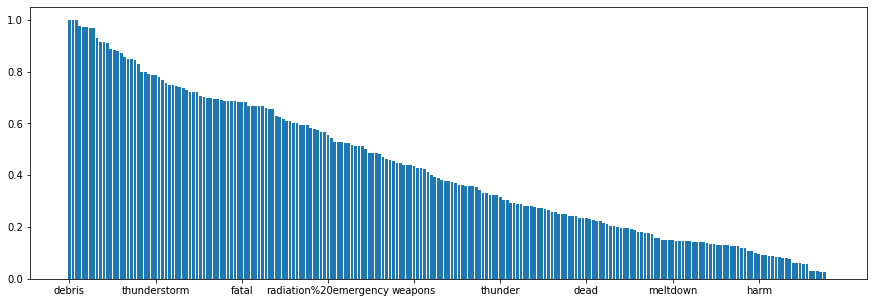

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.bar(keyword_group.sort_values('占比',ascending=False).index
       ,keyword_group.sort_values('占比',ascending=False)['占比'])
#輸出會跑出很多值
#該如何處理?
ax.set_xticks(np.arange(0, 220, 25))

### **2.2.3 location**

location列擁有的值<br>
大多數是以國家名以及城市地區為主<br>
不過其中仍然有些比較混雜的值<br>
例如:網站名稱、無法理解的詞、亂碼.<br> 

- 問題思考:
    1. 會不會有某些地區的留言與target值有關連性?

In [13]:
#排除掉location列值為nan的資料
#並挑幾筆拿出來

train[~train['location'].isna()].head(6)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [14]:
#了解location列包含哪些值以及其數量

print("{0:16}{1:1}".format('location值', '累計數量'))
print('')
print(train['location'].value_counts()[0:15])

print('')
print('-'*50)

print('location值:')
print(train['location'].unique()[0:30])

location值       累計數量

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64

--------------------------------------------------
location值:
[nan 'Birmingham' 'Est. September 2012 - Bristol' 'AFRICA'
 'Philadelphia, PA' 'London, UK' 'Pretoria' 'World Wide!!'
 'Paranaque City' 'Live On Webcam' 'milky way' 'GREENSBORO,NORTH CAROLINA'
 'England.' 'Sheffield Township, Ohio' 'India' 'Barbados' 'Anaheim'
 'Abuja' 'USA' 'South Africa' 'Sao Paulo, Brazil' 'hollywoodland '
 'Edmonton, Alberta - Treaty 6' 'Inang Pamantasan'
 'Twitter Lockout in progress' 'Concord, CA' 'Calgary, AB' 'San Francisco'
 'CLVLND' 'Nashville, TN']


### **2.2.4 text**

這邊加入文本每筆資料字和詞的數量會比較好<br>
在之後可以用於判斷padding值該設定為多少.<br>

In [15]:
#前20筆text

text=train['text'].values
num=0

for n in text:
    num+=1
    print(n)
    if num==20:
        break

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

### **2.2.5 target**

target用於表示text是否與災難有關

In [16]:
print('0和1個別總數:')
train.groupby('target')['target'].count()

0和1個別總數:


target
0    4342
1    3271
Name: target, dtype: int64

# **3. Data Preprocessing(資料前處理)**

經過上面的探索式分析<br>
判斷資料中大部分的列都不會是我們這次要帶入模型的資訊<br>
而這次會使用到的列有: text、target.<br>
我們需要對這些資料進行前處理.<br>

另外一點<br>
我們需要的columns中<br>
並沒有缺失值<br>
因此並不需要進行相關的處理.<br>

In [17]:
#超參數設定

max_length=70    #padding值

## **載入bert語言模型**

In [18]:
#導入berttokernizer並簡單測試

tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
test_text='Never put off what you can do today until tomorrow' 
clear_output()

#tokenizer其中10個tokens對應ids
print('-'*20)
for n in np.random.randint(0,len(tokenizer.get_vocab()),10):
    n=list(tokenizer.get_vocab().keys())[n] 
    print('{0:15}{1:1}'.format(n,tokenizer.get_vocab()[n]))

#tokenizer轉換測試
print('-'*20)
print('tokenizer轉換測試:')
print(tokenizer.encode(test_text))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(test_text)))

--------------------
##holders      17794
##wal          13476
##bby          14075
##ٹ            29838
whispers       11054
elsewhere      6974
huey           29503
pulitzer       17618
ರ              1401
chihuahua      28480
--------------------
tokenizer轉換測試:
[101, 2196, 2404, 2125, 2054, 2017, 2064, 2079, 2651, 2127, 4826, 102]
['[CLS]', 'never', 'put', 'off', 'what', 'you', 'can', 'do', 'today', 'until', 'tomorrow', '[SEP]']


In [19]:
#觀察文本轉換後的各別token總數

tokens=[]
for n in range(len(train['text'])):
    n=tokenizer.encode(train['text'][n])
    tokens.append(n)   
#len(tokens)

#可能會需要視覺化句子token數量
#這樣可以比較知道padding數值要設為多少
#這邊可以用隨機取樣的方式
for n in tokens[:10]:
    print(len(n), n[:20],'...')
    
max_seq_len = max([len(n) for n in tokens])
print('句子最大tokens數: ',max_seq_len)
    

16 [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102] ...
12 [101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 1012, 2710, 102] ...
27 [101, 2035, 3901, 2356, 2000, 1005, 7713, 1999, 2173, 1005, 2024, 2108, 19488, 2011, 3738, 1012, 2053, 2060, 13982, 2030] ...
14 [101, 2410, 1010, 2199, 2111, 4374, 1001, 3748, 26332, 13982, 4449, 1999, 2662, 102] ...
22 [101, 2074, 2288, 2741, 2023, 6302, 2013, 10090, 1001, 7397, 2004, 5610, 2013, 1001, 3748, 26332, 10364, 2015, 2046, 1037] ...
29 [101, 1001, 6857, 10273, 10651, 1027, 1028, 2662, 1044, 18418, 1012, 2322, 2701, 1999, 2119, 7826, 2349, 2000, 2697, 2221] ...
20 [101, 1001, 7186, 1001, 7071, 3082, 4542, 5320, 5956, 9451, 1997, 4534, 1999, 23624, 24826, 1010, 5169, 6076, 2752, 102] ...
22 [101, 1045, 1005, 1049, 2006, 2327, 1997, 1996, 2940, 1998, 1045, 2064, 2156, 1037, 2543, 1999, 1996, 5249, 1012, 1012] ...
16 [101, 2045, 1005, 1055, 2019, 5057, 13982, 6230, 2085, 1999, 1996, 2311, 2408,

## **轉換文本資料**

In [20]:
#轉換資料成model的input

#bert encoder.
#定義轉換資料的函式
#此函式將會把dataset轉換成model input
def encode(data):
    
    input_ids=[]
    attention_masks=[]

    for n in range(len(data)):
        #tokenizer.encode_plus 參數:
        #max_length 指定被補足的token數量
        #truncation 設定是否刪除超過max_length數量的token 
        input=tokenizer.encode_plus(data.text[n],
                                    add_special_tokens=True,
                                    padding='max_length',
                                    max_length=max_length,
                                    truncation=True,
                                    return_attention_mask=True,)

        input_ids.append(input['input_ids'])
        attention_masks.append(input['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)
        
#轉換資料        
input_ids, attention_masks=encode(train)
test_input_ids, test_attention_masks=encode(test)

#顯示處理後的資料
#model input
print('input_ids:')
for n in range(10):
    print(input_ids[n][:20],'...')
print('attention_masks:')
for n in range(10):
    print(attention_masks[n][:20],'...')

input_ids:
[  101  2256 15616  2024  1996  3114  1997  2023  1001  8372  2089 16455
  9641  2149  2035   102     0     0     0     0] ...
[  101  3224  2543  2379  2474  6902  3351 21871  2243  1012  2710   102
     0     0     0     0     0     0     0     0] ...
[  101  2035  3901  2356  2000  1005  7713  1999  2173  1005  2024  2108
 19488  2011  3738  1012  2053  2060 13982  2030] ...
[  101  2410  1010  2199  2111  4374  1001  3748 26332 13982  4449  1999
  2662   102     0     0     0     0     0     0] ...
[  101  2074  2288  2741  2023  6302  2013 10090  1001  7397  2004  5610
  2013  1001  3748 26332 10364  2015  2046  1037] ...
[  101  1001  6857 10273 10651  1027  1028  2662  1044 18418  1012  2322
  2701  1999  2119  7826  2349  2000  2697  2221] ...
[  101  1001  7186  1001  7071  3082  4542  5320  5956  9451  1997  4534
  1999 23624 24826  1010  5169  6076  2752   102] ...
[ 101 1045 1005 1049 2006 2327 1997 1996 2940 1998 1045 2064 2156 1037
 2543 1999 1996 5249 1012 101

# **4. Model**

在本次項目當中<br>
會使用三種不同的模型進行測試<br>
最後會挑出準確度最好的模型為test資料進行預測.<br>

問題思考:<br>
- 與範例的名行架構不同<br>
少了一個DENSE層<br>
這樣會有甚麼差別?<br>
準確度差異看起來並不是很大<br>
- 不同的batch size和epoch會分別有甚麼差別?<br>
epoch值設定的越大<br>
模型會更加的擬合traindata<br>
traindata準確度會變高<br>
不過即使如此<br>
在其他data上卻也不見得有如此的準確度.<br>
- 各個層的意義是甚麼?<br>
- activation有哪些差異?<br>
- 要如何套用TFBertForSequenceClassification到模型架構當中?<br>
如同model3的操作<br>
- 要如何紀錄模型訓練過程的checkpoint?<br>
印象中還有相關的蠻重要的用法<br>
那個是甚麼?<br>
- 原先的準確度大約在0.80~0.84間<br>
我應該做甚麼調整以提升準確度?<br>
如果修改drop可以提升valdata的準確度嗎?<br>
- 當batch_size超過一定值以後<br>
就會無法訓練<br>
這是為甚麼?<br>
- 三個模型的準確度分別為0.80140、0.82562、0.84247<br>
是模型的那些部分造成這些差異?<br>


觀察:
- 訓練的次數越多時<br>
訓練資料及的準確度會慢慢提升<br>
但是測試資料及的準確度並沒有提升.<br>
- 我有嘗試調整batch_size<br>
不過當超過一定值以後<br>
就會無法運行<br>
這是為甚麼?<br>
- 在這次定義的模型的訓練過程中<br>
提升訓練次數只有單獨提升traindata準確度<br>
而valdata並不會<br>
甚至是會降低.<br>

## **BERT模型導入**

In [21]:
#bert模型1

bertmodel1 = TFBertModel.from_pretrained('bert-base-uncased')


#顯示bertmodel配置
print('-'*20)
print(bertmodel1.config)
#顯示bert隱藏層
print('-'*20)
bertmodel1.layers

#顯示bertmodel 選定的隱藏層的配置
#bertmodel1.layers[n].get_config()
# bertmodel1.layers[0].get_config()

#顯示用bertmodel轉換後的值
# x1=tf.convert_to_tensor(input_ids)
# x2=tf.convert_to_tensor(attention_masks)
# bertmodel([x1,x2])

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-06-27 13:04:29.209137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 13:04:29.210313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 13:04:29.211001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 13:04:29.211987: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

--------------------
BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

--------------------


In [22]:
#bert模型2

#這邊需要注意
#在本次的案例中
#是要判斷文本'是'(1)或'否'(0)符合某個條件
#即為2元分類(應該是這個名字)
#因此最後的輸出的結果只要一個介於0到1之間的值.
#此處呼叫bert分類模型時需要加入參數num_labels設定
#參數值則為模型輸出值的數量

bertmodel2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=1)



#顯示bertmodel配置
print('-'*20)
print(bertmodel2.config)
#顯示bert隱藏層
print('-'*20)
bertmodel2.layers

#顯示bertmodel 選定的隱藏層的配置
#bertmodel2.layers[n].get_config()
# bertmodel2.layers[0].get_config()

#顯示用bertmodel轉換後的值
# x1=tf.convert_to_tensor(input_ids)
# x2=tf.convert_to_tensor(attention_masks)
# y=bertmodel2([x1[:50],x2[:50]])
# y

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------
BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

--------------------


##  **模型定義**

In [23]:
#模型1

def model1(bertmodel):
    
    #模型架構
    
    #模型輸入有兩個
    #因此設定兩個input
    input_ids = tf.keras.Input(shape=(70,),dtype='int64')
    attention_masks = tf.keras.Input(shape=(70,),dtype='int64')
    input=[input_ids,attention_masks]
    
    #bert_model
    output = bertmodel(input)    
    output = output[1]
    output = tf.keras.layers.Dense(32,activation="relu")(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation="sigmoid")(output)
    
    #最終的模型定義
    model = tf.keras.models.Model(inputs = input,outputs = output)
    #模型參數更新方式定義
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model


model1 = model1(bertmodel1)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
#模型2
#模型1架構少一個Dense層

def model2(bertmodel):

    #模型架構
    
    ids = tf.keras.Input(shape=(70,),dtype='int64')
    masks = tf.keras.Input(shape=(70,),dtype='int64')
    input=[ids,masks]

    output=bertmodel([ids,masks]) 
    output=output[1]
    output=tf.keras.layers.Dropout(0.2)(output)
    output=tf.keras.layers.Dense(1, activation='sigmoid')(output)   
    
    #最終的模型定義
    model=tf.keras.models.Model(inputs = input,outputs = output)
    #模型參數更新方式定義
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

model2=model2(bertmodel1)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_76 (Dropout)            (None, 768)          0           tf_bert_model[1][1]        

In [25]:
#模型3
#利用TFBertForSequenceClassification建構的模型

def model3(bertmodel):
    
    #模型架構
    
    ids = tf.keras.Input(shape=(70,),dtype='int64')
    masks = tf.keras.Input(shape=(70,),dtype='int64')
    input=[ids,masks]

    output=bertmodel([ids,masks])#輸出應該是word embedding. 
    output=output[0]
    
    #最終的模型定義
    model=tf.keras.models.Model(inputs = input,outputs = output)
    #模型參數更新方式定義
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])   
    return model
    

model3=model3(bertmodel2)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 109483009   input_5[0][0]                    
                                                                 input_6[0][0]                    
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
__________________________________________________________________________________________________


## **模型訓練**

In [26]:
%%time
#訓練模型

history1 = model1.fit(
    [input_ids,attention_masks],
    train['target'],
    validation_split=0.2,
    epochs=2,
    batch_size=10)

history2 = model2.fit(
    [input_ids,attention_masks],
    train['target'],
    validation_split=0.2,
    epochs=2,
    batch_size=10)

history3 = model3.fit(
    [input_ids,attention_masks],
    train['target'],
    validation_split=0.2,
    epochs=2,
    batch_size=10)

2022-06-27 13:04:49.280071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
609/609 [==============================] - 83s 121ms/step - loss: 0.4879 - accuracy: 0.7777 - val_loss: 0.3771 - val_accuracy: 0.8418
Epoch 2/2
609/609 [==============================] - 71s 117ms/step - loss: 0.3620 - accuracy: 0.8534 - val_loss: 0.3676 - val_accuracy: 0.8359
Epoch 1/2
609/609 [==============================] - 83s 121ms/step - loss: 0.3293 - accuracy: 0.8768 - val_loss: 0.3897 - val_accuracy: 0.8385
Epoch 2/2
609/609 [==============================] - 71s 116ms/step - loss: 0.2571 - accuracy: 0.9041 - val_loss: 0.4006 - val_accuracy: 0.8359
Epoch 1/2
609/609 [==============================] - 83s 121ms/step - loss: 0.6160 - accuracy: 0.7284 - val_loss: 0.6131 - val_accuracy: 0.8293
Epoch 2/2
609/609 [==============================] - 71s 117ms/step - loss: 0.4832 - accuracy: 0.8213 - val_loss: 0.6531 - val_accuracy: 0.8418
CPU times: user 6min 57s, sys: 51.9 s, total: 7min 49s
Wall time: 7min 41s


In [27]:
print('-'*30)
print('model1')
for n in history1.history:
    print('{}: {}'.format(n,history1.history[n]))
    
print('-'*30)
print('model2')
for n in history2.history:
    print('{}: {}'.format(n,history2.history[n]))
    
print('-'*30)
print('model3')
for n in history3.history:
    print('{}: {}'.format(n,history3.history[n]))

------------------------------
model1
loss: [0.4879293441772461, 0.36200445890426636]
accuracy: [0.777668297290802, 0.8533661961555481]
val_loss: [0.377141535282135, 0.3675609230995178]
val_accuracy: [0.8417596817016602, 0.8358502984046936]
------------------------------
model2
loss: [0.32930463552474976, 0.2570752203464508]
accuracy: [0.8768472671508789, 0.9041050672531128]
val_loss: [0.3896868824958801, 0.4006107747554779]
val_accuracy: [0.8384767174720764, 0.8358502984046936]
------------------------------
model3
loss: [0.6160247921943665, 0.4832397997379303]
accuracy: [0.7284072041511536, 0.8213464617729187]
val_loss: [0.6130563020706177, 0.6530736684799194]
val_accuracy: [0.8292843103408813, 0.8417596817016602]


# **submission**

經過數次從頭訓練模型的過程<br>
發現定義的這三個模型最後的準確度<br>
都差不多在0.80~0.84這個區間<br>
也並沒有一定是哪個模型有更高的準確度.<br>

這邊猜測<br>
應該是三個模型的架構和配置都太接近了<br>
之後可以嘗試差異更大的架構和配置.<br>

In [28]:
#以testdatset進行預測結果
test_y1=model1.predict([test_input_ids,test_attention_masks]) 
test_y2=model2.predict([test_input_ids,test_attention_masks]) 
test_y3=model3.predict([test_input_ids,test_attention_masks]) 

In [29]:
#把預測結果製作競賽的格式

submission1=pd.read_csv('../input/nlp-getting-started/sample_submission.csv') 
submission2=pd.read_csv('../input/nlp-getting-started/sample_submission.csv') 
submission3=pd.read_csv('../input/nlp-getting-started/sample_submission.csv') 
for n,m,num in zip([submission1,submission2,submission3],[test_y1,test_y2,test_y3],[1,2,3]):
    n['target']=np.round(m).astype('int')
    n.to_csv('submission{}'.format(num),index=False)  

submission1.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
